<a href="https://colab.research.google.com/github/sparshsinha123/EUA/blob/main/EdgeUserAllocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edge User Allocation with common deadlines


In [ ]:
!pip install pulp

     |████████████████████████████████| 40.6MB 72kB/s 


In [ ]:
import pandas as pd
import pulp as pl
import numpy as np
from functools import cmp_to_key

In [ ]:
FILENAME = '2.csv'
df = pd.read_csv(FILENAME)
df.head()

,Unnamed: 0,siteId,serverLat,serverLong,coverage,uId,userLat,userLong,SCPU,SSTO,SBAN,SRAM,UCPU,URAM,UST,UBAN
0,0,1000,-12.471947,130.845073,139.740864,388,-12.5144,130.9688,1.000000,16.694195,7.191424,1.00000,1,2,1,2
1,1,1000,-12.471947,130.845073,139.740864,431,-12.3912,130.8905,1.000000,16.694195,7.191424,1.00000,1,2,1,2
2,2,1000,-12.471947,130.845073,139.740864,432,-12.4572,130.8366,1.000000,16.694195,7.191424,1.00000,2,3,3,4
3,3,1000,-12.471947,130.845073,139.740864,433,-12.3807,130.8854,1.000000,16.694195,7.191424,1.00000,5,7,6,6
4,4,10000,-33.756158,150.698182,104.433753,95,-33.8675,151.2070,32.693898,9.733423,30.515704,27.52511,1,2,1,2


### Separating the user and server data frames and preparing the data

In [ ]:
## separating the users data frame and the server data frame into seperate data frames
## storing the coverage information of the servers in dictionary
userdf = df[['uId' , 'UCPU' , 'URAM' , 'UST' , 'UBAN']]
userdf = userdf.drop_duplicates(keep = 'first')

serverdf = df[['siteId' , 'coverage' , 'SCPU' , 'SSTO' , 'SBAN' , 'SRAM']]
serverdf = serverdf.drop_duplicates(keep = 'first')

## dictionary to store the coverage of the servers
coverage = {}
serversites = serverdf['siteId'].tolist()

for st in serversites:
  new_df = df.loc[df['siteId'] == st]
  ulist = new_df.uId.tolist()
  coverage[st] = ulist

In [ ]:
serverdf.head()

,siteId,coverage,SCPU,SSTO,SBAN,SRAM
0,1000,139.740864,1.000000,16.694195,7.191424,1.000000
4,10000,104.433753,32.693898,9.733423,30.515704,27.525110
70,10000002,147.708035,12.130151,1.000000,14.943381,8.367748
72,10000003,101.405127,20.052630,6.911655,15.411686,27.173734
76,10000006,123.580381,6.932951,4.380761,1.000000,7.897172


### Edge user allocation as a integer programming problem

In [ ]:
%%time
## getting all the necessary values for the linear programming formulation
common_deadline = 10
num_servers = serverdf.shape[0]
num_users = userdf.shape[0]

print("the common deadline for the tasks is " + str(common_deadline))
print("number of servers are " + str(num_servers))
print("number of users are " + str(num_users))
print("the common deadline for the execution of tasks is " + str(common_deadline))

## getting the list of all the server resources
servercpu = np.array(serverdf['SCPU'].tolist())
serverstorage = np.array(serverdf['SSTO'].tolist())
serverram = np.array(serverdf['SRAM'].tolist())
serverbandwidth = np.array(serverdf['SBAN'].tolist())
serverid = np.array(serverdf['siteId'].tolist())


## getting the list of all the user resources
MEAN = 2
STDDEV = 1
usercpu = np.array(userdf['UCPU'].tolist())
userstorage = np.array(userdf['UST'].tolist())
userram = np.array(userdf['URAM'].tolist())
userbandwidth = np.array(userdf['UBAN'].tolist())
userid = np.array(userdf['uId'].tolist())

## randomly generating the execution time for the users 
userexecutiontime = np.round(np.array(np.random.normal(MEAN , STDDEV , num_users)))
userexecutiontime = [max(i , 0) for i in userexecutiontime]

def is_in_coverage_of(j , i):
  ## whether the jth user is in coverage of the ith server or not
  site_id_of_server = serverid[i]
  user_id_of_user = userid[j]
  cover = coverage[site_id_of_server]
  if user_id_of_user in cover:
    return 1
  else:
    return 0


the common deadline for the tasks is 10
number of servers are 47
number of users are 343
the common deadline for the execution of tasks is 10
CPU times: user 3.61 ms, sys: 125 µs, total: 3.73 ms
Wall time: 3.3 ms


In [ ]:
def linear_programming_solution():
    server_user_time_vars = [[["x_{0}_{1}_{2}".format(i , j , t) for t in range(common_deadline)] for j in range(num_users)] for i in range(num_servers)]
    server_time_vars = [["y_{0}_{1}".format(i , t) for t in range(common_deadline)] for i in range(num_servers)]

    ## setting up the variables for the linear programming
    ## X[i][j][t] is whether the jth user is allocated to the ith server at time t or not
    ## Y[i][t] is whether the ith server is active at t

    X = [[[pl.LpVariable(server_user_time_vars[i][j][t], 0, 1, cat='Integer') for t in range(common_deadline)] for j in range(num_users)] for i in range(num_servers)]
    Y = [[pl.LpVariable(server_time_vars[i][t] , 0 , 1 , cat='Integer') for t in range(common_deadline)]for i in range(num_servers)]

    ## create the optimization problem as the maximization problem
    linearprogram = pl.LpProblem("euasolver", pl.LpMaximize)

    ## setting up the resource constraint equations 
    for t in range(common_deadline):
      for i in range(num_servers):

        ## cpu constraint at time t 
        constraintcpu = X[i][0][t] * usercpu[0]
        for j in range(1 , num_users):
          constraintcpu += X[i][j][t] * usercpu[j]
        constraintcpu -= Y[i][t] * servercpu[i]

        linearprogram += constraintcpu <= 0

        ## storage constraint at time t
        constraintstorage = X[i][0][t] * userstorage[0]
        for j in range(1 , num_users):
          constraintstorage += X[i][j][t] * userstorage[j]
        constraintstorage -= Y[i][t] * serverstorage[i]

        linearprogram += constraintstorage <= 0

        ## ram constraints at time t
        constraintram = X[i][0][t] * userram[0]
        for j in range(1 , num_users):
          constraintram += X[i][j][t] * userram[j]
        constraintram -= Y[i][t] * serverram[i]

        linearprogram += constraintram <= 0

        ## bandwidth constraint at time t
        constraintbandwidth = X[i][0][t] * userbandwidth[0]
        for j in range(1 , num_users):
          constraintbandwidth += X[i][j][t] * userbandwidth[j]
        constraintbandwidth -= Y[i][t] * serverbandwidth[i]

        linearprogram += constraintbandwidth <= 0


    ## at any time t one user must go to one server only
    for t in range(common_deadline):
      for j in range(num_users):
        serverconstraint = X[0][j][t]
        for i in range(1 , num_servers):
          serverconstraint += X[i][j][t];

        linearprogram += serverconstraint <= 1

    
    ## proximity constraint at any time t
    for i in range(num_servers):
      for j in range(num_users):
        ## find if the user is in coverage of the current server
        is_user_in_server_coverage = df.loc[(df.siteId == serverid[i]) & (df.uId == userid[j])].shape[0]
        
        if is_user_in_server_coverage == 0:
          ## if the user is not in the coverage of the server then for all the times the value of X[i][j][t] must be zero
          for t in range(common_deadline):
            user_out_of_coverage_constraint = X[i][j][t]
            linearprogram += user_out_of_coverage_constraint <= 0 
            linearprogram += user_out_of_coverage_constraint >= 0     


    ## Making the system migration free
    ## z_i_j = 1 if the jth user was allocated to the ith server
    ## other wise 0

    migration_control = [["z_{0}_{1}".format(i , j) for j in range(num_users)] for i in range(num_servers)]

    Z = [[pl.LpVariable(migration_control[i][j] , 0 , 1 , cat='Integer') for j in range(num_users)] for i in range(num_servers)]

    ## for a particular user we must have only one server to which it belongs
    for j in range(num_users):
      migration_constraint = Z[0][j]
      for i in range(1 , num_servers):
        migration_constraint += Z[i][j]

      linearprogram += migration_constraint <= 1


    ## the user must be only allocated to one server for the total sum of its execution time only
    for i in range(num_servers):
      for j in range(num_users):
        constraint_execution_time = X[i][j][0]
        for t in range(1 , common_deadline):  
          constraint_execution_time += X[i][j][t]
        
        linearprogram += constraint_execution_time <= Z[i][j] * userexecutiontime[j]
        linearprogram += constraint_execution_time >= Z[i][j] * userexecutiontime[j]

    obj = 0
    for i in range(num_servers):
      for t in range(common_deadline):
        for j in range(num_users):
          obj += X[i][j][t]

    linearprogram += obj


    ## print the solution of the linear programming problem
    print("solving the linear programming problem... ")
    status = linearprogram.solve()

    if status == pl.LpStatusOptimal:
      print("the optimal solutions are : ") 
      num_users_allocated = 0
      for i in range(num_servers):
        for j in range(num_users):
          for t in range(common_deadline):
            num_users_allocated += pl.value(X[i][j][t])
      
      avg_users_allocated = (1.00 * num_users_allocated) / (common_deadline) 

      print("average number of users allocated: " + str(avg_users_allocated))
      
      total_servers_used = 0
      for i in range(num_servers):
        for t in range(common_deadline):
          total_servers_used += pl.value(Y[i][t])
      
      avg_servers_used = (1.00 * total_servers_used) / (common_deadline)
      print("average number of servers used: " + str(avg_servers_used))
      return avg_servers_used
    else:
      print("unable to find the optimal solution")
      return -1

%time
usrs_allocated = linear_programming_solution()
print("the number of users allocated " + str(usrs_allocated))


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
solving the linear programming problem... 
the optimal solutions are : 
average number of users allocated: 33.0
average number of servers used: 47.0
the number of users allocated 47.0


## HEURISTIC SOLUTIONS

### SORTING ON THE BASIS OF EXECUTION TIME

In [ ]:
## performs the allocation of the users to the servers based on the comparators passed in
def perform_user_allocation(usr_key , server_key , verbose = False):
    ## sorting the users and servers on the basis of the key
    userslist = [i for i in range(num_users)]
    serverlist = [i for i in range(num_servers)]
    userslist.sort(key = usr_key)
    serverlist.sort(key = server_key)

    ## forming the allocation dictionary for the users 
    allocated = {}
    ## maintaining the used servers
    servers_used = {}
    ## maintaining the execution time of the users
    exectime = userexecutiontime.copy() 
    ## create the map of users to servers at time t
    user_server_map = [[[0 for t in range(common_deadline)] for j in range(num_users)] for i in range(num_servers)]

    for t in range(common_deadline):
      ## for each time instant upto the common deadline do the following 
      
      ## get the server resources
      scpu = servercpu.copy()
      sstorage = serverstorage.copy()
      sram = serverram.copy()
      sbandwidth = serverbandwidth.copy()
      
      ## utility function to perform the allocation of a user to the server
      def allocate(j , i):
        ## allocate the jth user to the ith server
          scpu[i] = scpu[i] - usercpu[j] 
          sstorage[i] = sstorage[i] - userstorage[j] 
          sram[i] = sram[i] - userram[j] 
          sbandwidth[i] = sbandwidth[i] - userbandwidth[j]
      
      def canbeallocated(j , i):
      # whether the jth user can be allocated to ith server or not
          if is_in_coverage_of(j , i) == 0:
            return 0
          if usercpu[j] > scpu[i]:
            return 0
          if userstorage[j] > sstorage[i]:
            return 0
          if userram[j] > sram[i]:
            return 0
          if userbandwidth[j] > sbandwidth[i]:
            return 0
 
          return 1

      for j in range(num_users):
        usr = userslist[j]
        
        # if the users execution time is over then ignore and continue
        if exectime[usr] <= 0:
          continue

        # if the user has already been allocated to a server then try allocate him to it again
        if usr in allocated:
          server_used = allocated[usr] ## get the server to which he was allocated
          allocate(usr , server_used) ## allocate him to the same server
          exectime[usr] -= 1 ## one unit of execution time is done 
          user_server_map[server_used][usr][t] = 1 ## usr has been allocated to the server so mark him in the map
          servers_used[server_used] = 1 ## this server is marked as used
        else:
          ## try to allocate the user to the starting from left to right
          for i in range(num_servers): 
            srvr = serverlist[i] ## this is the server that we are trying to allocate the user to
            if canbeallocated(usr , srvr) == 1: ## we check if the user can be allocated to the server
              allocate(usr , srvr) ## if yes, we do the allocation
              allocated[usr] = srvr ## mark the user as allocated 
              exectime[usr] -= 1    ## reduce the execution time of the user
              user_server_map[srvr][usr][t] = 1 ## store the mapping in the map
              servers_used[srvr] = 1 ## mark the server as used
              break

    ## allocation is done 
    avgusers = 0 ## calculate the average number of users that have been allocated

    ## simply take sum from the map
    for i in range(num_servers):
      for j in range(num_users):
        for t in range(common_deadline):
          avgusers += user_server_map[i][j][t]

    avgusers = (1.00 * avgusers) / (common_deadline)

    avgserversused = (1.00 * len(servers_used)) / common_deadline
    if verbose == True:
      print ("the average number of users allocated " + str(avgusers))
      print ("the average number of servers used " + str(avgserversused))
    return avgusers
    

#### RANDOM ALLOCATION


In [ ]:
def random_allocation():
    def userscompare(i , j):
      if i < j:
        return -1
      elif i == j:
        return 0
      else:
        return 1

    def serverscompare(i , j):
      if i < j:
        return -1
      elif i == j:
        return 0
      else:
        return 1
        
    return perform_user_allocation(cmp_to_key(userscompare) , cmp_to_key(serverscompare))
res = random_allocation()
print("users allocated = " + str(res))

users allocated = 29.9


### USERS SORTED ON THE BASIS OF EXECUTION TIME



In [ ]:
def greedy_allocation():
    def userscompare(i , j):
      ei = userexecutiontime[i]
      ej = userexecutiontime[j]
      if ei < ej:
        return -1
      elif ei > ej:
        return 1
      else:    
        return 0

    def serverscompare(i , j):
      if i < j:
        return -1
      elif i == j:
        return 0
      else:
        return 1

    return perform_user_allocation(cmp_to_key(userscompare) , cmp_to_key(serverscompare))
  
res = greedy_allocation()
print("users_allocated = " + str(res))

users_allocated = 30.7


### USERS SORTED ON THE BASIS OF EXECUTION TIME AND SERVERS ON THE BASIS OF CAPACITY

In [ ]:
def most_capacity_first():
  def userscompare(i , j):
    ei = userexecutiontime[i]
    ej = userexecutiontime[j]
    if ei < ej:
      return -1
    elif ei > ej:
      return 1
    else:    
      return 0

  def serverscompare(i , j):
    scapacityi = servercpu[i] + serverram[i] + serverbandwidth[i] + serverstorage[i]
    scapacityj = servercpu[j] + serverram[j] + serverbandwidth[j] + serverstorage[j]

    if scapacityi < scapacityj:
      return -1
    elif scapacityi > scapacityj:
      return 1
    else:    
      return 0

  return perform_user_allocation(cmp_to_key(userscompare) , cmp_to_key(serverscompare))
res = most_capacity_first()
print("users = " + str(res))

users = 31.3


### SORTING BASED ON SOME PARAMETERS

In [ ]:
%time
## for user we do a1 * resources + (1 - a1) * execution time = a1 * outgoing_edges + (1 - a1) * execution_time
## for servers we do b1 * (weight_of_incoming edges) + (1 - b1) * resources available
results = pd.DataFrame()
A = []
B = []
C = []
def parameter_based_sorting():
    hyperparameter_a = [0.1 , 0.3 , 0.5 , 0.7 , 0.9 , 1.00]
    hyperparameter_b = [0.1 , 0.3 , 0.5 , 0.7 , 0.9 , 1.00]

    ## computing the results in the results data frame
    users_allocated = 0
    for a1 in hyperparameter_a:
      for b1 in hyperparameter_b:
        def get_user_cost(j):
          cost = (a1 / 4.00) * (usercpu[j] + userstorage[j] + userram[j] + userbandwidth[j]) + (1 - a1) * userexecutiontime[j]
          return cost

        def get_server_cost(i):
          server_coverage = len(coverage[serverid[i]])
          cost = (b1 / 4.00) * (servercpu[i] + serverstorage[i] + serverram[i] + serverbandwidth[i]) + (1 - b1) * server_coverage
          return cost
        def userscompare(i , j):
          ## measure the cost of the ith user
          ui = get_user_cost(i)
          ## measure the cost of the jth user
          uj = get_user_cost(j)
          if ui < uj:
            return -1
          elif ui > uj:
            return 1
          else:    
            return 0

        def serverscompare(i , j):
          ## measure the cost of the ith server
          si = get_server_cost(i)
          ## measure the cost of the jth server
          sj = get_server_cost(j)

          if si < sj:
            return -1
          elif si > sj:
            return 1
          else:
            return 0
        allocation = perform_user_allocation(cmp_to_key(userscompare) , cmp_to_key(serverscompare))
        A.append(a1)
        B.append(b1)
        C.append(allocation)
        users_allocated = max(users_allocated , allocation)
    results['A'] = A
    results['B'] = B
    results['U'] = C
    return users_allocated
res = parameter_based_sorting()
print("users = " + str(res))
results.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs
users = 31.0


,A,B,U
0,0.1,0.1,30.5
1,0.1,0.3,30.5
2,0.1,0.5,30.5
3,0.1,0.7,30.5
4,0.1,0.9,30.5


### PLOTTING THE RESULTS TO SEE THE OPTIMAL HYPERPARAMETERS

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### THE VARIATION OF THE RESULTS WITH PARAMETER 'A'

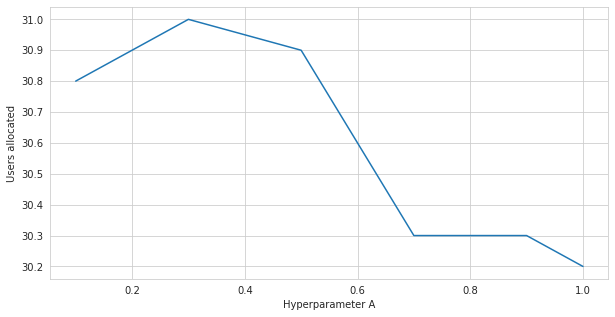

In [ ]:
a_dependence = results.groupby(['A']).max().reset_index()
sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
sns.lineplot(x = a_dependence['A'] , y = a_dependence['U'])
plt.xlabel('Hyperparameter A')
plt.ylabel('Users allocated')
plt.show()

### VARIATION OF RESULTS WITH THE PARAMETER 'B'

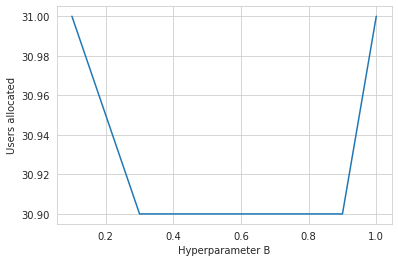

In [ ]:
b_dependence = results.groupby(['B']).max().reset_index()
sns.lineplot(x = b_dependence['B'] , y = b_dependence['U'])
plt.xlabel('Hyperparameter B')
plt.ylabel('Users allocated')
plt.show()